In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
from janitor.chemistry import morgan_fingerprint
from mlxtend.evaluate import cochrans_q, mcnemar, mcnemar_table
from tqdm.notebook import tqdm
from itertools import combinations
from delong_ci import calc_auc_ci
from scipy.stats import wilcoxon
from mlxtend.evaluate import paired_ttest_5x2cv

A few settings to make things look better

In [2]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [3]:
pd.set_option('precision', 2)

Read the data

In [4]:
df = pd.read_csv("chembl_herg_log_activity.csv")

In [5]:
df.head()

,smiles,pIC50
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73


Plot the data distribution

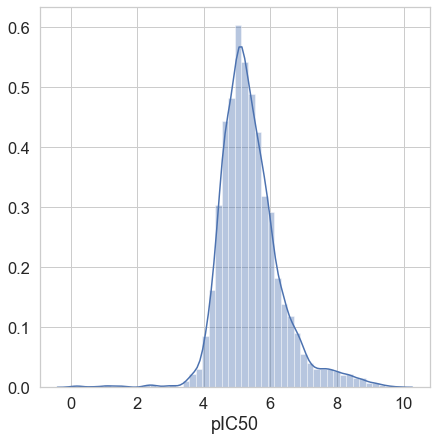

In [6]:
sns.distplot(df.pIC50)

Label the molecules with IC50 <- 1uM (pIC >= 6) as active

In [7]:
df['active'] = df.pIC50 >= 6

In [8]:
df.head()

,smiles,pIC50,active
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25,True
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03,False
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15,False
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75,True
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73,True


Add Morgan fingerprints

In [9]:
morgan_df =morgan_fingerprint(df=df.smiles2mol('smiles', 'mols'),mols_column_name='mols',kind='bits')

In [10]:
df = df.join(morgan_df)

In [11]:
fp_cols = df.columns[4:]

Perform 10 cycles of cross validation

In [29]:
method_list = [XGBClassifier, RandomForestClassifier, LGBMClassifier]
method_name_list = [x().__class__.__name__ for x in method_list]
method_name_list = [x.replace("Classifier","") for x in method_name_list]
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10
for i in tqdm(range(0,cv_cycles)):
    train, test = train_test_split(df)
    cycle_pred = []
    cycle_prob = []
    for method in method_list:
        cls = method(n_jobs=-1)
        cls.fit(train[fp_cols],train.active)
        cycle_pred.append(cls.predict(test[fp_cols]))
        cycle_prob.append(cls.predict_proba(test[fp_cols]))
        
    truth_list.append(test.active.values)        
    pred_list.append(cycle_pred)
    prob_list.append(cycle_prob)

Collect AUCs for the models above

In [30]:
auc_result = []
for truth, prob in zip(truth_list,prob_list):
    for name, p in zip(method_name_list, prob):
        auc_result.append([name,roc_auc_score(truth,p[:,1])])
auc_df = pd.DataFrame(auc_result,columns=["Method","AUC"])

Most papers I see show barplots with "whisker" showing the standard deviation for multiple replicates. **Please don't do this**

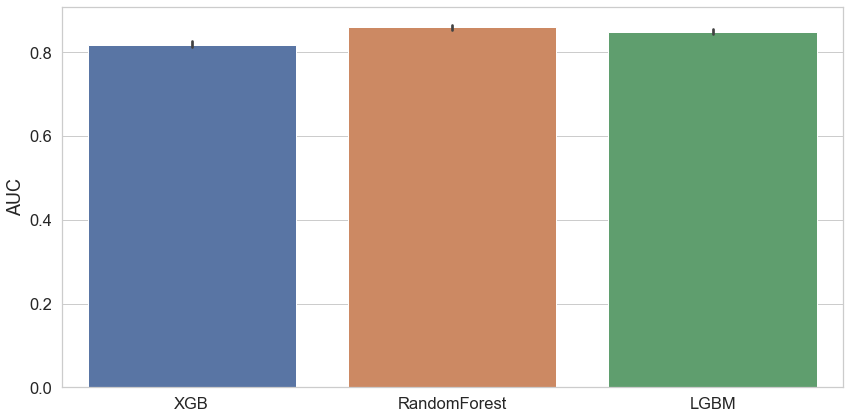

In [31]:
ax = sns.barplot(x="Method",y="AUC",data=auc_df)
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set(xticklabels=labels)
_ = ax.set(xlabel="")

An alternate, and still less than correct, approach is to plot the replicates as box plots.  

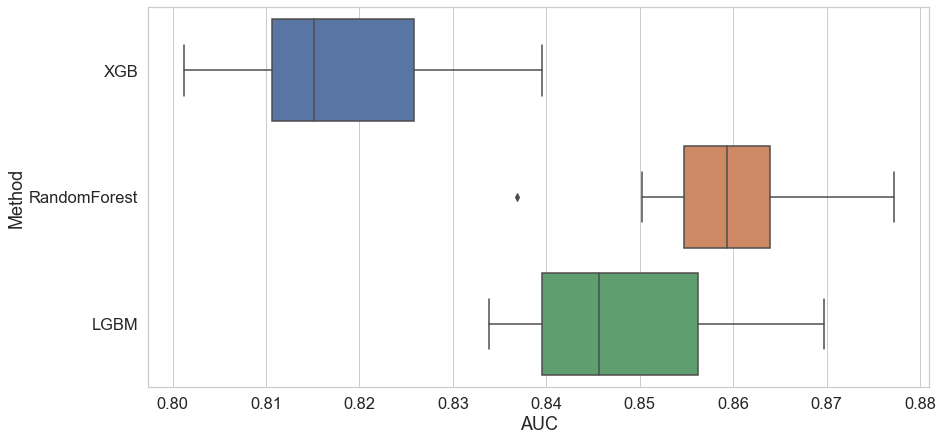

In [32]:
ax = sns.boxplot(y="Method",x="AUC",data=auc_df)

#### 1. Confidence Intervals for AUC
Use DeLong's method to calculate the confidence interval for an AUC

In [33]:
auc_result = []
for cycle, [truth, prob] in enumerate(zip(truth_list,prob_list)):
    for name, p in zip(method_name_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth,p[:,1])
        auc_result.append([cycle,name, auc, lb, ub])
auc_ci_df = pd.DataFrame(auc_result,columns=["Cycle","Method","AUC","LB","UB"])
auc_ci_df.head()

,Cycle,Method,AUC,LB,UB
0,0,XGB,0.81,0.78,0.84
1,0,RandomForest,0.85,0.82,0.88
2,0,LGBM,0.84,0.82,0.87
3,1,XGB,0.82,0.79,0.84
4,1,RandomForest,0.85,0.83,0.88


In [34]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('white')

We can now plot the AUC with confidence interval for each CV cycle with a confidence interval. 

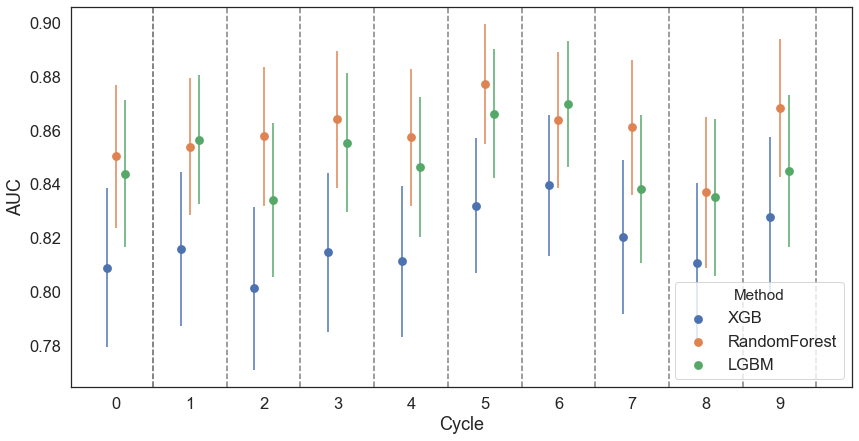

In [35]:
dodge_val = 0.25
palette_name = "deep"
ax = sns.pointplot(x="Cycle",y="AUC",hue="Method",data=auc_ci_df,dodge=dodge_val,join=False,palettte=palette_name)
colors = sns.color_palette(palette_name, len(auc_ci_df.Method.unique())) * cv_cycles
ax.axvline(0.5,ls="--",c="gray")
for x in np.arange(0.5,cv_cycles,1):
    ax.axvline(x,ls="--",c="gray")
y_val = auc_ci_df.AUC
lb = y_val - auc_ci_df.LB
ub = auc_ci_df.UB - y_val
x_pos = []
for i in range(0,cv_cycles):
    x_pos += [i-dodge_val/2,i,i+dodge_val/2]
_ = ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color=colors)

#### 2. 5x2-fold cross validation

In [36]:
X = df[fp_cols].values
y = df.active.values
classifier_list = [x(n_jobs=-1) for x in method_list]
print(f"{'Method_1':12s} {'Method_2':12s} {'p-value'}")
for a,b in combinations(zip(classifier_list,method_name_list),2):
    clf1,name1 = a
    clf2,name2 = b
    t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=X, y=y, scoring="roc_auc")
    print(f"{name1:12s} {name2:12s} {p:.3f}")

Method_1     Method_2     p-value
XGB          RandomForest 0.012
XGB          LGBM         0.216
RandomForest LGBM         0.326


#### 3. McNemar's Test

In [20]:
mc_result = []
for truth, pred in zip(truth_list,pred_list): 
    for i,j in combinations(range(len(method_list)),2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mc_result.append([method_name_list[i],method_name_list[j], mc_pvalue])
mc_df = pd.DataFrame(mc_result,columns=["Method_1","Method_2","p_value"])
mc_df['Combo'] = mc_df.Method_1 + "_" + mc_df.Method_2
mc_df.head()

,Method_1,Method_2,p_value,Combo
0,XGB,RandomForest,7.95e-02,XGB_RandomForest
1,XGB,LGBM,3.54e-03,XGB_LGBM
2,RandomForest,LGBM,1.22e-01,RandomForest_LGBM
3,XGB,RandomForest,1.10e-02,XGB_RandomForest
4,XGB,LGBM,1.68e-01,XGB_LGBM


#### 4. Account for Multiple Testing
Calculate the Bonferroni correction for the p-value that will be considered significant.  

In [21]:
alpha = 0.05/len(pred_list[0])
alpha

0.016666666666666666

Generate a boxplot of with the p-value for the McNemar coefficient for each pair of comparisons

In [22]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

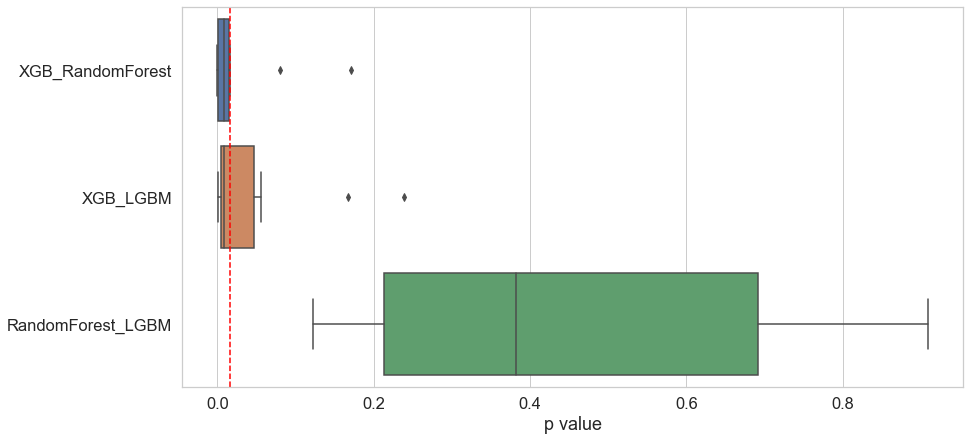

In [23]:
ax = sns.boxplot(x="p_value",y="Combo",data=mc_df)
ax.set(ylabel="",xlabel="p value")
_ = ax.axvline(alpha,c="red",ls="--")